# Fraud Detection

### Project Overview
* Build a model to detect fraudulant transactions from an extremely imbalanced financial dataset.
* Cleaned, explored and manipulated the entire data extensively on Python to make it usable for our use case.
* Investigated the data and engineered new features as and when necessary in accordance with our project requirements.
* Applied Synthetic Minority Over-sampling Technique (SMOTE) and other measures to overcome extreme imbalance before modelling the classifier

#### Project Introduction
In this project, I will be trying to detect fraudulant transactions from a financial dataset containing over 6 million records of transactions. The dataset is extremely imbalanced with minority (fraud) proportion. I will be trying to implement various measures to tackle the challenges and arrive at an acceptable fraud detection performance.

### Loading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("Fraud.csv")

### Understanding the dataset

In [3]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Features reference:

* step: represents a unit of time where 1 step equals 1 hour
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction

In [4]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
data.shape

(6362620, 11)

In [6]:
# Check for null values
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# Check for data types
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [8]:
# Check for minority class proportion
minority_prop = round((data['isFraud'].value_counts()[1]/len(data))*100,3)
print("Minority(Fraud) Proportion: ",minority_prop," %")

Minority(Fraud) Proportion:  0.129  %


We have extremely imbalanced dataset with minority class proportion of 0.129% of total number of records.

### Data Investigation and Exploration:
First, we start by splitting the dataset into fraud and valid transactions datasets. Then we will be comparing the stats among each to pick up points of interest and patters that might help while building the detection model. We will also be discarding features that we find irrelevant to our project objective.

In [9]:
# splitting dataset into fraud and valid transaction
frauddf = data[data['isFraud']==1]
nofrauddf = data[data['isFraud']==0]

#### Feature: "step"

In [10]:
print("Fraud DF:\n", frauddf["step"].describe().round(2), "\n\nValid DF:\n", nofrauddf["step"].describe().round(2))

Fraud DF:
 count    8213.00
mean      368.41
std       216.39
min         1.00
25%       181.00
50%       367.00
75%       558.00
max       743.00
Name: step, dtype: float64 

Valid DF:
 count    6354407.00
mean         243.24
std          142.14
min            1.00
25%          156.00
50%          239.00
75%          334.00
max          718.00
Name: step, dtype: float64


We can infer two things:
* As step is the time of 1 unit = 1hr and as the dataframe represent data for one month, we can find out during which time of month fraud transaction and non fraud transactions happen most.
* We can convert this step into hourOfDay to find out which time of day fraud and non fraud transactions happen most.

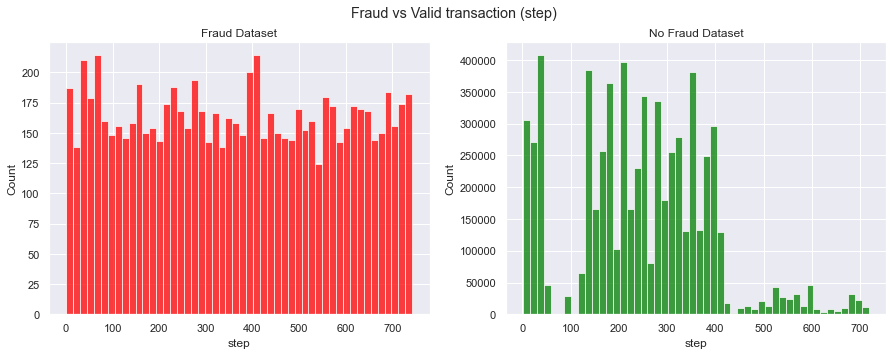

In [11]:
# Plot the histogram of both fraud and valid df step feature
sns.set()
figure, axes = plt.subplots(1,2, figsize=(15,5))
figure.suptitle("Fraud vs Valid transaction (step)")
sns.histplot(ax=axes[0],data=frauddf['step'], bins=50, color='red')
sns.histplot(ax=axes[1],data=nofrauddf['step'], bins=50, color='green')
axes[0].set_title("Fraud Dataset")
axes[1].set_title("No Fraud Dataset")
plt.show()

Fraud transactions are happening throughout the month while valid transactions happen mostly in first half of the month.

Similarly, visulizing the transactions throughout the day

In [12]:
frauddf['hourOfDay'] = frauddf['step']%24
nofrauddf['hourOfDay'] = nofrauddf['step']%24
data['hourOfDay'] = data['step']%24

<ipython-input-12-c42cd526eed1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frauddf['hourOfDay'] = frauddf['step']%24
<ipython-input-12-c42cd526eed1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nofrauddf['hourOfDay'] = nofrauddf['step']%24


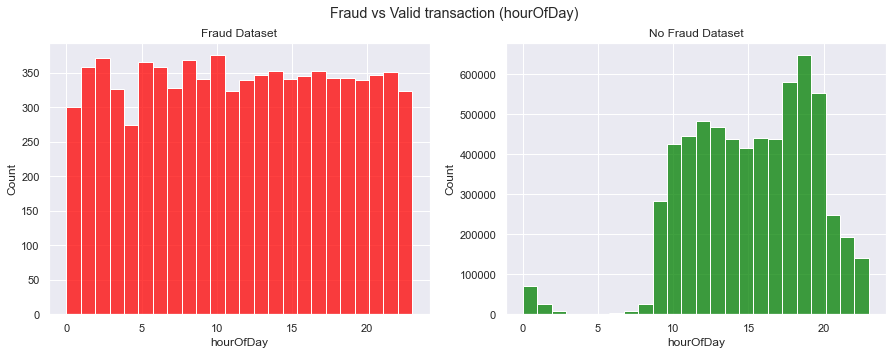

In [13]:
# Plot the histogram of both fraud and valid df step feature
figure, axes = plt.subplots(1,2, figsize=(15,5))
figure.suptitle("Fraud vs Valid transaction (hourOfDay)")
sns.histplot(ax=axes[0],data=frauddf['hourOfDay'], bins=24, color='red')
sns.histplot(ax=axes[1],data=nofrauddf['hourOfDay'], bins=24, color='green')
axes[0].set_title("Fraud Dataset")
axes[1].set_title("No Fraud Dataset")
plt.show()

Again, we can see that fraud transactions happen throughout the day where valid transactions have a pattern which seems logical. Therefore we will use this feature for analysis.

#### Feature: "type"

In [14]:
print("Fraud DF:\n", frauddf["type"].value_counts(), "\n\nValid DF:\n", nofrauddf["type"].value_counts())

Fraud DF:
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64 

Valid DF:
 CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64


We can see an important result that fraud transactions happen only in "CASH_OUT" and "TRANSFER" method. Therefore, we should drop all other transaction types from our dataset as they serve no purpose in fraud transaction

In [15]:
data = data[(data['type']=="CASH_OUT") | (data['type']=="TRANSFER")]

In [16]:
# again initialize the fraud and valid transaction df for analysis
frauddf = data[data['isFraud']==1]
nofrauddf = data[data['isFraud']==0]

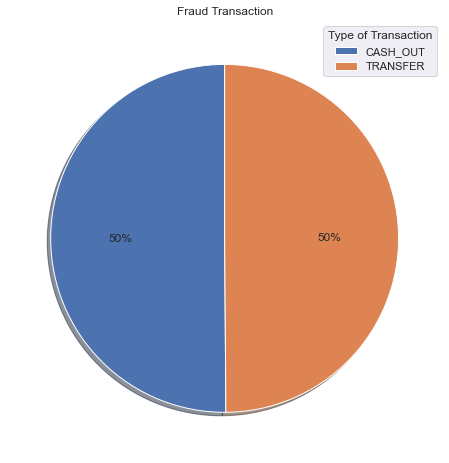

<Figure size 576x576 with 0 Axes>

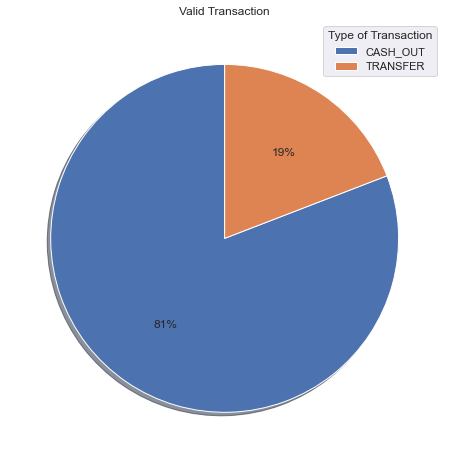

In [17]:
# Exploring further, analyzing the transaction type in pie charts.
plt.figure(figsize=(8,8))
plt.pie(x=frauddf['type'].value_counts(), startangle=90, shadow=True, autopct='%1.00f%%')
plt.title("Fraud Transaction")
plt.legend(title='Type of Transaction', loc='upper right', labels=['CASH_OUT','TRANSFER'])
plt.show()
plt.figure(figsize=(8,8))
plt.figure(figsize=(8,8))
plt.pie(x=nofrauddf['type'].value_counts(), startangle=90, shadow=True, autopct='%1.00f%%')
plt.title("Valid Transaction")
plt.legend(title='Type of Transaction', loc='upper right', labels=['CASH_OUT','TRANSFER'])
plt.show()


#### Feature: "amount"

In [18]:
print("Fraud DF:\n", frauddf["amount"].describe().round(1), "\n\nValid DF:\n", nofrauddf["amount"].describe().round(1))

Fraud DF:
 count        8213.0
mean      1467967.3
std       2404252.9
min             0.0
25%        127091.3
50%        441423.4
75%       1517771.5
max      10000000.0
Name: amount, dtype: float64 

Valid DF:
 count     2762196.0
mean       314115.5
std        877144.1
min             0.0
25%         82908.2
50%        171034.5
75%        305994.2
max      92445516.6
Name: amount, dtype: float64


Some interesting points:

* Fraud transactions amount is capped at exactly 10 million units whereas valid transactions amount goes all the way upto 92 million units.
* Mean of fraud and valid transaction amount is way higher than their respective median indicating high presence of outliers.
* Fraud transaction amounts are generally higher than valid transaction amounts.

In [19]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hourOfDay
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


We see that **"newbalanceOrig"** + **"amount"** should equal to **"oldbalanceOrg"** and also **"oldbalanceDest"** + **"amount"** should equal to **"newbalanceDest"**. We will try to verify this before proceeding ahead and also check if there are any discrepencies.

In [20]:
print("Percentages (new balance origin + amount = old balance origin): \n", ((data["newbalanceOrig"] + data["amount"]) == data["oldbalanceOrg"]).value_counts(normalize=True).round(2)*100)

Percentages (new balance origin + amount = old balance origin): 
 False    91.0
True      9.0
dtype: float64


We see that only 9% of the data has no errors in the details related to origin balances and amount. This looks very interesting so we will create a new feature "origin error amount" in our model.

In [21]:
print("Percentages (old balance dest + amount = new balance dest): \n", ((data["oldbalanceDest"] + data["amount"]) == data["newbalanceDest"]).value_counts(normalize=True).round(2)*100)

Percentages (old balance dest + amount = new balance dest): 
 True     58.0
False    42.0
dtype: float64


We see that 42% of the data has errors in the details related to destination balances and amount. Similarly, we will again create a new feature "destination error amount" in our model.

In [22]:
data["origin_error"] = (data["newbalanceOrig"] + data["amount"]) - data["oldbalanceOrg"]

data["dest_error"] = (data["oldbalanceDest"] + data["amount"]) - data["newbalanceDest"]

#### Feature: "nameOrig" and "nameDest"

In [23]:
# we check transactions from new origin names and existing origin names
print("Total Origin Names:", len(data["nameOrig"]))
print("Unique Origin Names:", len(data["nameOrig"].unique()))
print("Transactions from existing Origin Names:", len(data["nameOrig"]) - len(data["nameOrig"].unique()))

Total Origin Names: 2770409
Unique Origin Names: 2768630
Transactions from existing Origin Names: 1779


In [24]:
# we check transactions to new destination names and existing destination names
print("Total Destination Names:", len(data["nameDest"]))
print("Unique Destination Names:", len(data["nameDest"].unique()))
print("Transactions to existing Destination Names:", len(data["nameDest"]) - len(data["nameDest"].unique()))

Total Destination Names: 2770409
Unique Destination Names: 509565
Transactions to existing Destination Names: 2260844


We see that there are very few transactions that started from existing origin names but there are quite a lot of transactions that were made to existing destination names.

We see that this two features will not show any significance in detecting fraud transactions so we will be dropping them from our model.

In [25]:
# dropped nameOrig and nameDest
data.drop(columns=["nameOrig", "nameDest"], axis=1, inplace=True)

#### Feature: "isFlaggedFraud"

In [26]:
# we check the value counts
data["isFlaggedFraud"].value_counts()

0    2770393
1         16
Name: isFlaggedFraud, dtype: int64

In [27]:
# all transactions where isFlaggedFraud is 1
data[data["isFlaggedFraud"] == 1]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hourOfDay,origin_error,dest_error
2736446,212,TRANSFER,4953893.08,4953893.08,4953893.08,0.0,0.0,1,1,20,4953893.08,4953893.08
3247297,250,TRANSFER,1343002.08,1343002.08,1343002.08,0.0,0.0,1,1,10,1343002.08,1343002.08
3760288,279,TRANSFER,536624.41,536624.41,536624.41,0.0,0.0,1,1,15,536624.41,536624.41
5563713,387,TRANSFER,4892193.09,4892193.09,4892193.09,0.0,0.0,1,1,3,4892193.09,4892193.09
5996407,425,TRANSFER,10000000.00,19585040.37,19585040.37,0.0,0.0,1,1,17,10000000.00,10000000.00
5996409,425,TRANSFER,9585040.37,19585040.37,19585040.37,0.0,0.0,1,1,17,9585040.37,9585040.37
6168499,554,TRANSFER,3576297.10,3576297.10,3576297.10,0.0,0.0,1,1,2,3576297.10,3576297.10
6205439,586,TRANSFER,353874.22,353874.22,353874.22,0.0,0.0,1,1,10,353874.22,353874.22
6266413,617,TRANSFER,2542664.27,2542664.27,2542664.27,0.0,0.0,1,1,17,2542664.27,2542664.27
6281482,646,TRANSFER,10000000.00,10399045.08,10399045.08,0.0,0.0,1,1,22,10000000.00,10000000.00


We can notice that all transactions with very high amount are marked as fraud. This will only create a bias in our model, therefore we drop this feature as it does not show any significance.

In [28]:
# dropped isFlaggedFraud feature
data.drop(columns=["isFlaggedFraud"], axis=1, inplace=True)

Final Dataset before processing:

In [29]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hourOfDay,origin_error,dest_error
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,1,0.00,181.0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,1,0.00,21363.0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,1,213808.94,182703.5
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,1,214605.30,237735.3
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,1,300850.89,-2401220.0


### Linear Correlation with Response Variable

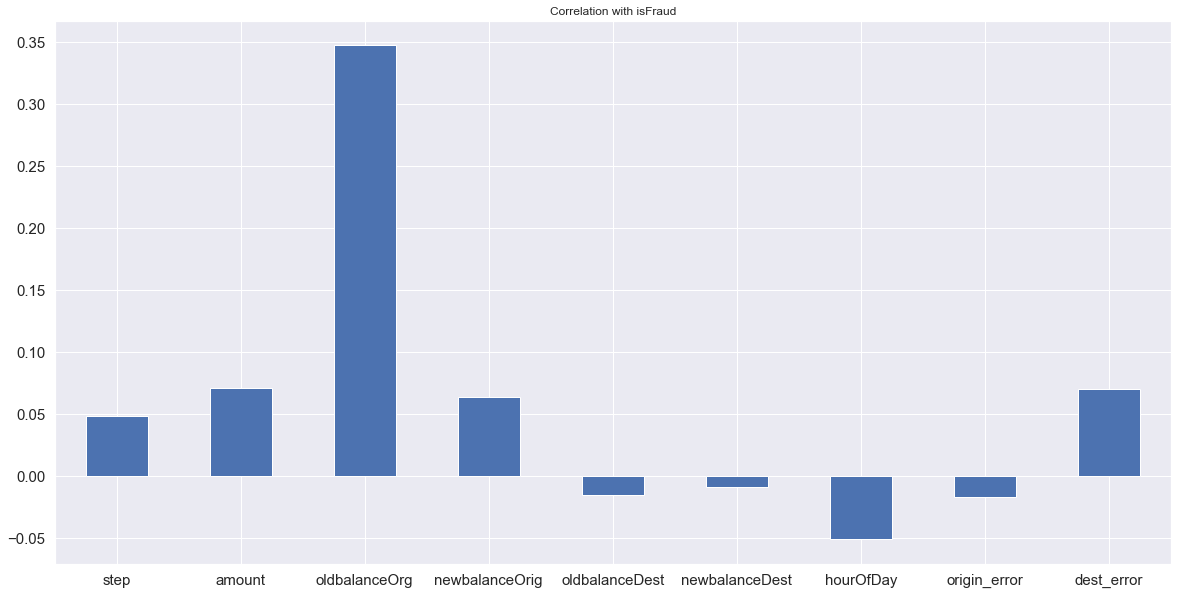

In [30]:
data2 = data.drop(columns='isFraud')
data2.corrwith(data.isFraud).plot.bar(figsize=(20,10), title="Correlation with isFraud", fontsize=15, rot=0,grid=True)
plt.show()

* An easy interpretation from this could be that the oldBalanceOrig shows the highest positive correlation. This means, mostly higher oldBalanceOrig is a fraud transaction.
* Other values of correlation does not show any major correlation with "isFraud" feature

# Outlier

Since the model going to be used in this case is Random Forest(decided after considering the features and the data), outliers are normalized and feature scaling is not required.

# Pre-processing

In [31]:
X = data.iloc[:, data.columns!="isFraud"]
y = data.iloc[:, data.columns=='isFraud']

#### One hot encoding

In [32]:
X=X.join(pd.get_dummies(X[['type']]))

In [33]:
X.drop(columns=['type'],axis=1,inplace=True)
X_copy = X.copy()

In [34]:
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hourOfDay,origin_error,dest_error,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,1,213808.94,182703.5,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,1,214605.30,237735.3,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,1,300850.89,-2401220.0,0,1


In [35]:
y.head()

,isFraud
2,1
3,1
15,0
19,0
24,0


#### Scaling
We will use standard scaler to scale our dataset

In [36]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X = scaler.fit_transform(X)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [38]:
X_train.shape

(2077806, 11)

In [39]:
X_test.shape

(692603, 11)

In [40]:
y_train.value_counts()

isFraud
0          2071685
1             6121
dtype: int64

#### Synthetic Minority Over-sampling Technique (SMOTE)
We will be using SMOTE to balance the classes in our dataset. SMOTE is a widely used technique that works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [41]:
# we use SMOTE to balance the classes in our training set

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=10)
X_res, y_res = sm.fit_resample(X_train, y_train)
# we check if the classes are balanced
print("Percentages of classes 0 and 1:\n", y_res.value_counts(normalize=True)*100)

Percentages of classes 0 and 1:
 isFraud
1          50.0
0          50.0
dtype: float64


# Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
random_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [44]:
# random_forest.fit(X_train,y_train.values.ravel())
random_forest.fit(X_res,y_res.values.ravel())

RandomForestClassifier(n_jobs=-1)

In [45]:
y_pred = random_forest.predict(X_test)

### Evaluation

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, PrecisionRecallDisplay
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690511
           1       0.98      1.00      0.99      2092

    accuracy                           1.00    692603
   macro avg       0.99      1.00      0.99    692603
weighted avg       1.00      1.00      1.00    692603



In [47]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
print('accuracy:%0.6f'%acc,'\nprecision:%0.6f'%prec,'\nrecall:%0.6f'%rec,'\nF1-score:%0.6f'%f1)


accuracy:0.999934 
precision:0.981638 
recall:0.996654 
F1-score:0.989089


Accuracy just shows how much correct predictions are done by model. This ignores any false positives or true negatives.
Precision talks about how precise the model is; out of those predicted positive, how many of them are acual positive. (Useful for our fraud detection from customers' end)(high cost associated with False Positive).
Recall talks about how precise the model is; out of those actual positive, how many of them are predicted positive. (Useful for our fraud detection from banks' end)(high cost associated with False Negative).
F1 score: It might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

### ROC Curve

C:\Users\MAYANK RAJ\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


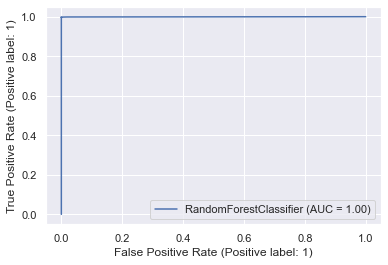

In [48]:
ROC_RF = plot_roc_curve(random_forest,X_test,y_test)
plt.show()

### Confusion Matrix

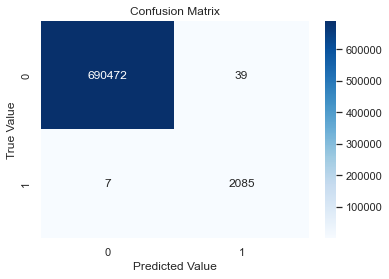

In [49]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.show()

We see that we have a pretty solid model with near perfect evaluation scores. Hence, we will not try to perform any hyper parameter tuning or any further changes.

# Important features in model prediction

In [50]:
sorted_index = random_forest.feature_importances_.argsort()[::-1][:11]
sorted_index

array([ 7,  2,  3,  5,  1,  8,  6,  4,  0,  9, 10], dtype=int64)

In [51]:
X_copy.columns[sorted_index]

Index(['origin_error', 'oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest',
       'amount', 'dest_error', 'hourOfDay', 'oldbalanceDest', 'step',
       'type_CASH_OUT', 'type_TRANSFER'],
      dtype='object')

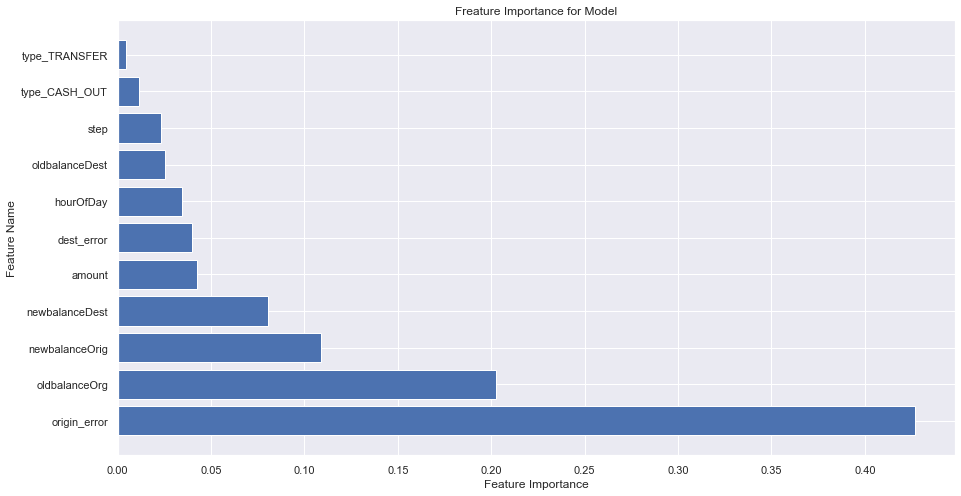

In [52]:
plt.figure(figsize=(15,8))
plt.barh(X_copy.columns[sorted_index], random_forest.feature_importances_[sorted_index])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Freature Importance for Model")
plt.show()

#### Conclusion:
We see that we have achieved fruitful results. We were able to build a model from an extremely imbalanced dataset that can detect fraud transactions with near perfect accuracy. This concludes our project till here.

Data Source: [Link](https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset)